<a href="https://colab.research.google.com/github/w4bo/teaching-handsondatapipelines/blob/main/materials/16_ASAI_Hackathon_Diabetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The `Diabetes` challenge

### Goal

It is your job to predict the `Outcome` of diabetes for each patient.

### TODO

You are allowed to use `numpy`, `pandas`, `matplotlib`, `sns`, and `sk-learn` Python libraries. You can import any model from `sk-learn`.

You are asked to fulfill the following steps; remember to write your insights on the dataset in the card below.

1. Feature pre-processing (e.g., remove useless features, impute missing values, encode some features)
2. Verify the distribution of "Outcome" values
3. Check pairwise correlations among features
4. Split training and test data. When splitting train and test datasets, the test dataset should contain 30% of the data.
5. Plot the training dataset in 2D, are the outcomes separated?
6. Train at least two ML classification models; submissions are evaluated using the accuracy score.
7. Perform hyperparameter optimization for at least one model

In [67]:
# Briefly explain *HERE* the overall steps of your solution (e.g., what did you do and why).
# Briefly write the extracted outcome/insights of each of the previous points here.

In [68]:
!pip install "flaml[automl]"
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from scipy.stats import randint
import seaborn as sns
from sklearn import metrics


# SEED all random generators
seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)

df = pd.read_csv("https://raw.githubusercontent.com/w4bo/handsOnDataPipelines/main/materials/datasets/diabetes.mod.csv")
df

,Unnamed: 0,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0,6,148,72,35,0,33.6,0.627,50,Y
1,1,1,85,66,29,0,26.6,0.351,31,N
2,2,8,183,64,0,0,23.3,0.672,32,Y
3,3,1,89,66,23,94,28.1,0.167,21,N
4,4,0,137,40,35,168,43.1,2.288,33,Y
...,...,...,...,...,...,...,...,...,...,...
763,763,10,101,76,48,180,32.9,0.171,63,N
764,764,2,122,70,27,0,36.8,0.340,27,N
765,765,5,121,72,23,112,26.2,0.245,30,N
766,766,1,126,60,0,0,30.1,0.349,47,Y


# Esplorazione del dominio

- Cos'è il diabete?
- Come si diagnostica?
- Qual è il significato delle variabili che abbiamo a disposizione

Dataset del '94

In [69]:
# Rimozione colonna index non necessaria
df.drop(columns=df.columns[0], axis=1,  inplace=True)

In [70]:
# BMI ha dei valori nulli, Outcome è categorico
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       755 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    object 
dtypes: float64(2), int64(6), object(1)
memory usage: 54.1+ KB


In [71]:
# 500 non diabetici, 268 diabetici
df['Outcome'].value_counts()

Outcome
N    500
Y    268
Name: count, dtype: int64

In [72]:
# 5 positivi, 8 negativi con BMI nullo
df = df[df['BMI'].notnull()]

In [73]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,755.000000,755.000000,755.000000,755.000000,755.000000,755.000000,755.000000,755.000000
mean,3.854305,121.172185,68.998675,20.472848,79.713907,31.992450,0.472114,33.210596
std,3.381172,31.667445,19.454190,15.991302,115.565133,7.951837,0.331941,11.784398
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.200000,0.243500,24.000000
50%,3.000000,117.000000,72.000000,23.000000,29.000000,32.300000,0.370000,29.000000
75%,6.000000,141.000000,80.000000,32.000000,126.500000,36.600000,0.628000,41.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000


In [74]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,Y
1,1,85,66,29,0,26.6,0.351,31,N
2,8,183,64,0,0,23.3,0.672,32,Y
3,1,89,66,23,94,28.1,0.167,21,N
4,0,137,40,35,168,43.1,2.288,33,Y
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,N
764,2,122,70,27,0,36.8,0.340,27,N
765,5,121,72,23,112,26.2,0.245,30,N
766,1,126,60,0,0,30.1,0.349,47,Y


In [75]:
def convert_to_binary(value):
    if value == 'Y':
        return 1
    elif value == 'N':
        return 0
    else:
        return None

df['Outcome'] = df['Outcome'].apply(convert_to_binary)

<ipython-input-75-aad953319106>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Outcome'] = df['Outcome'].apply(convert_to_binary)


In [76]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,755.000000,755.000000,755.000000,755.000000,755.000000,755.000000,755.000000,755.000000,755.000000
mean,3.854305,121.172185,68.998675,20.472848,79.713907,31.992450,0.472114,33.210596,0.348344
std,3.381172,31.667445,19.454190,15.991302,115.565133,7.951837,0.331941,11.784398,0.476762
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.200000,0.243500,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,29.000000,32.300000,0.370000,29.000000,0.000000
75%,6.000000,141.000000,80.000000,32.000000,126.500000,36.600000,0.628000,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


<Axes: >

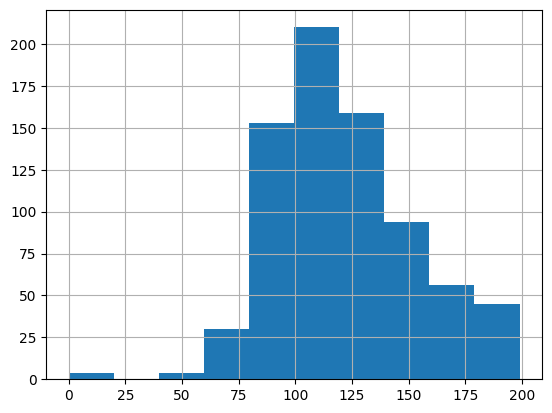

In [77]:
df["Glucose"].hist(bins=10)

<Axes: >

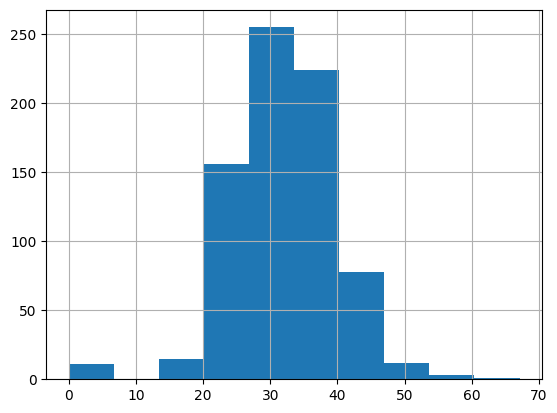

In [78]:
df["BMI"].hist()

<Axes: >

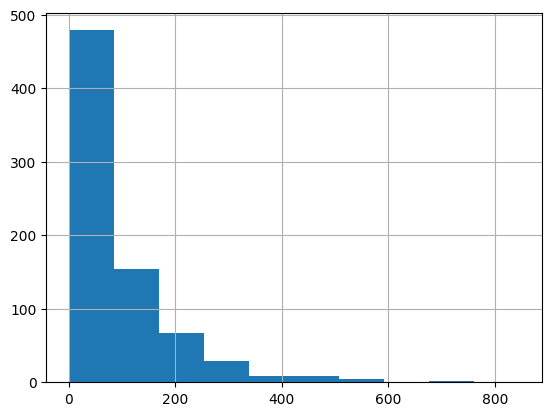

In [79]:
df["Insulin"].hist(bins=10)

<Axes: >

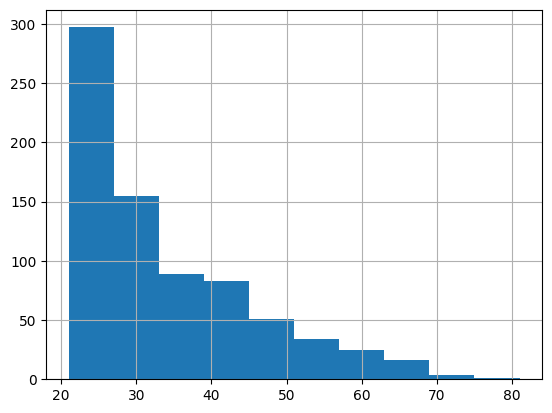

In [80]:
df["Age"].hist(bins=10)

<Axes: >

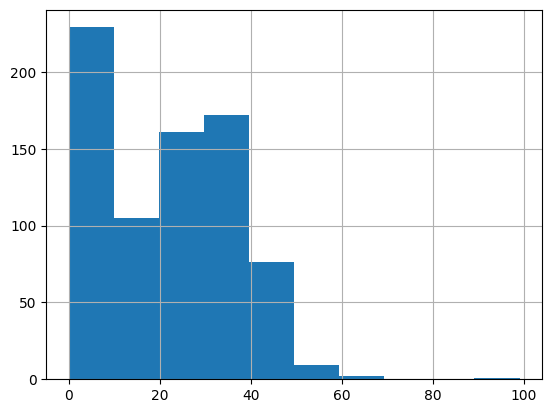

In [81]:
df["SkinThickness"].hist()

In [82]:
(df == 0).sum(axis=0)

Pregnancies                 110
Glucose                       4
BloodPressure                35
SkinThickness               225
Insulin                     368
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                     492
dtype: int64

In [83]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 755 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               755 non-null    int64  
 1   Glucose                   755 non-null    int64  
 2   BloodPressure             755 non-null    int64  
 3   SkinThickness             755 non-null    int64  
 4   Insulin                   755 non-null    int64  
 5   BMI                       755 non-null    float64
 6   DiabetesPedigreeFunction  755 non-null    float64
 7   Age                       755 non-null    int64  
 8   Outcome                   755 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 59.0 KB


<Axes: >

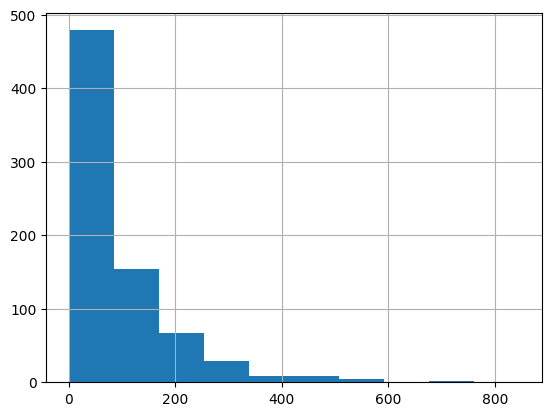

In [84]:
df['Insulin'].hist()

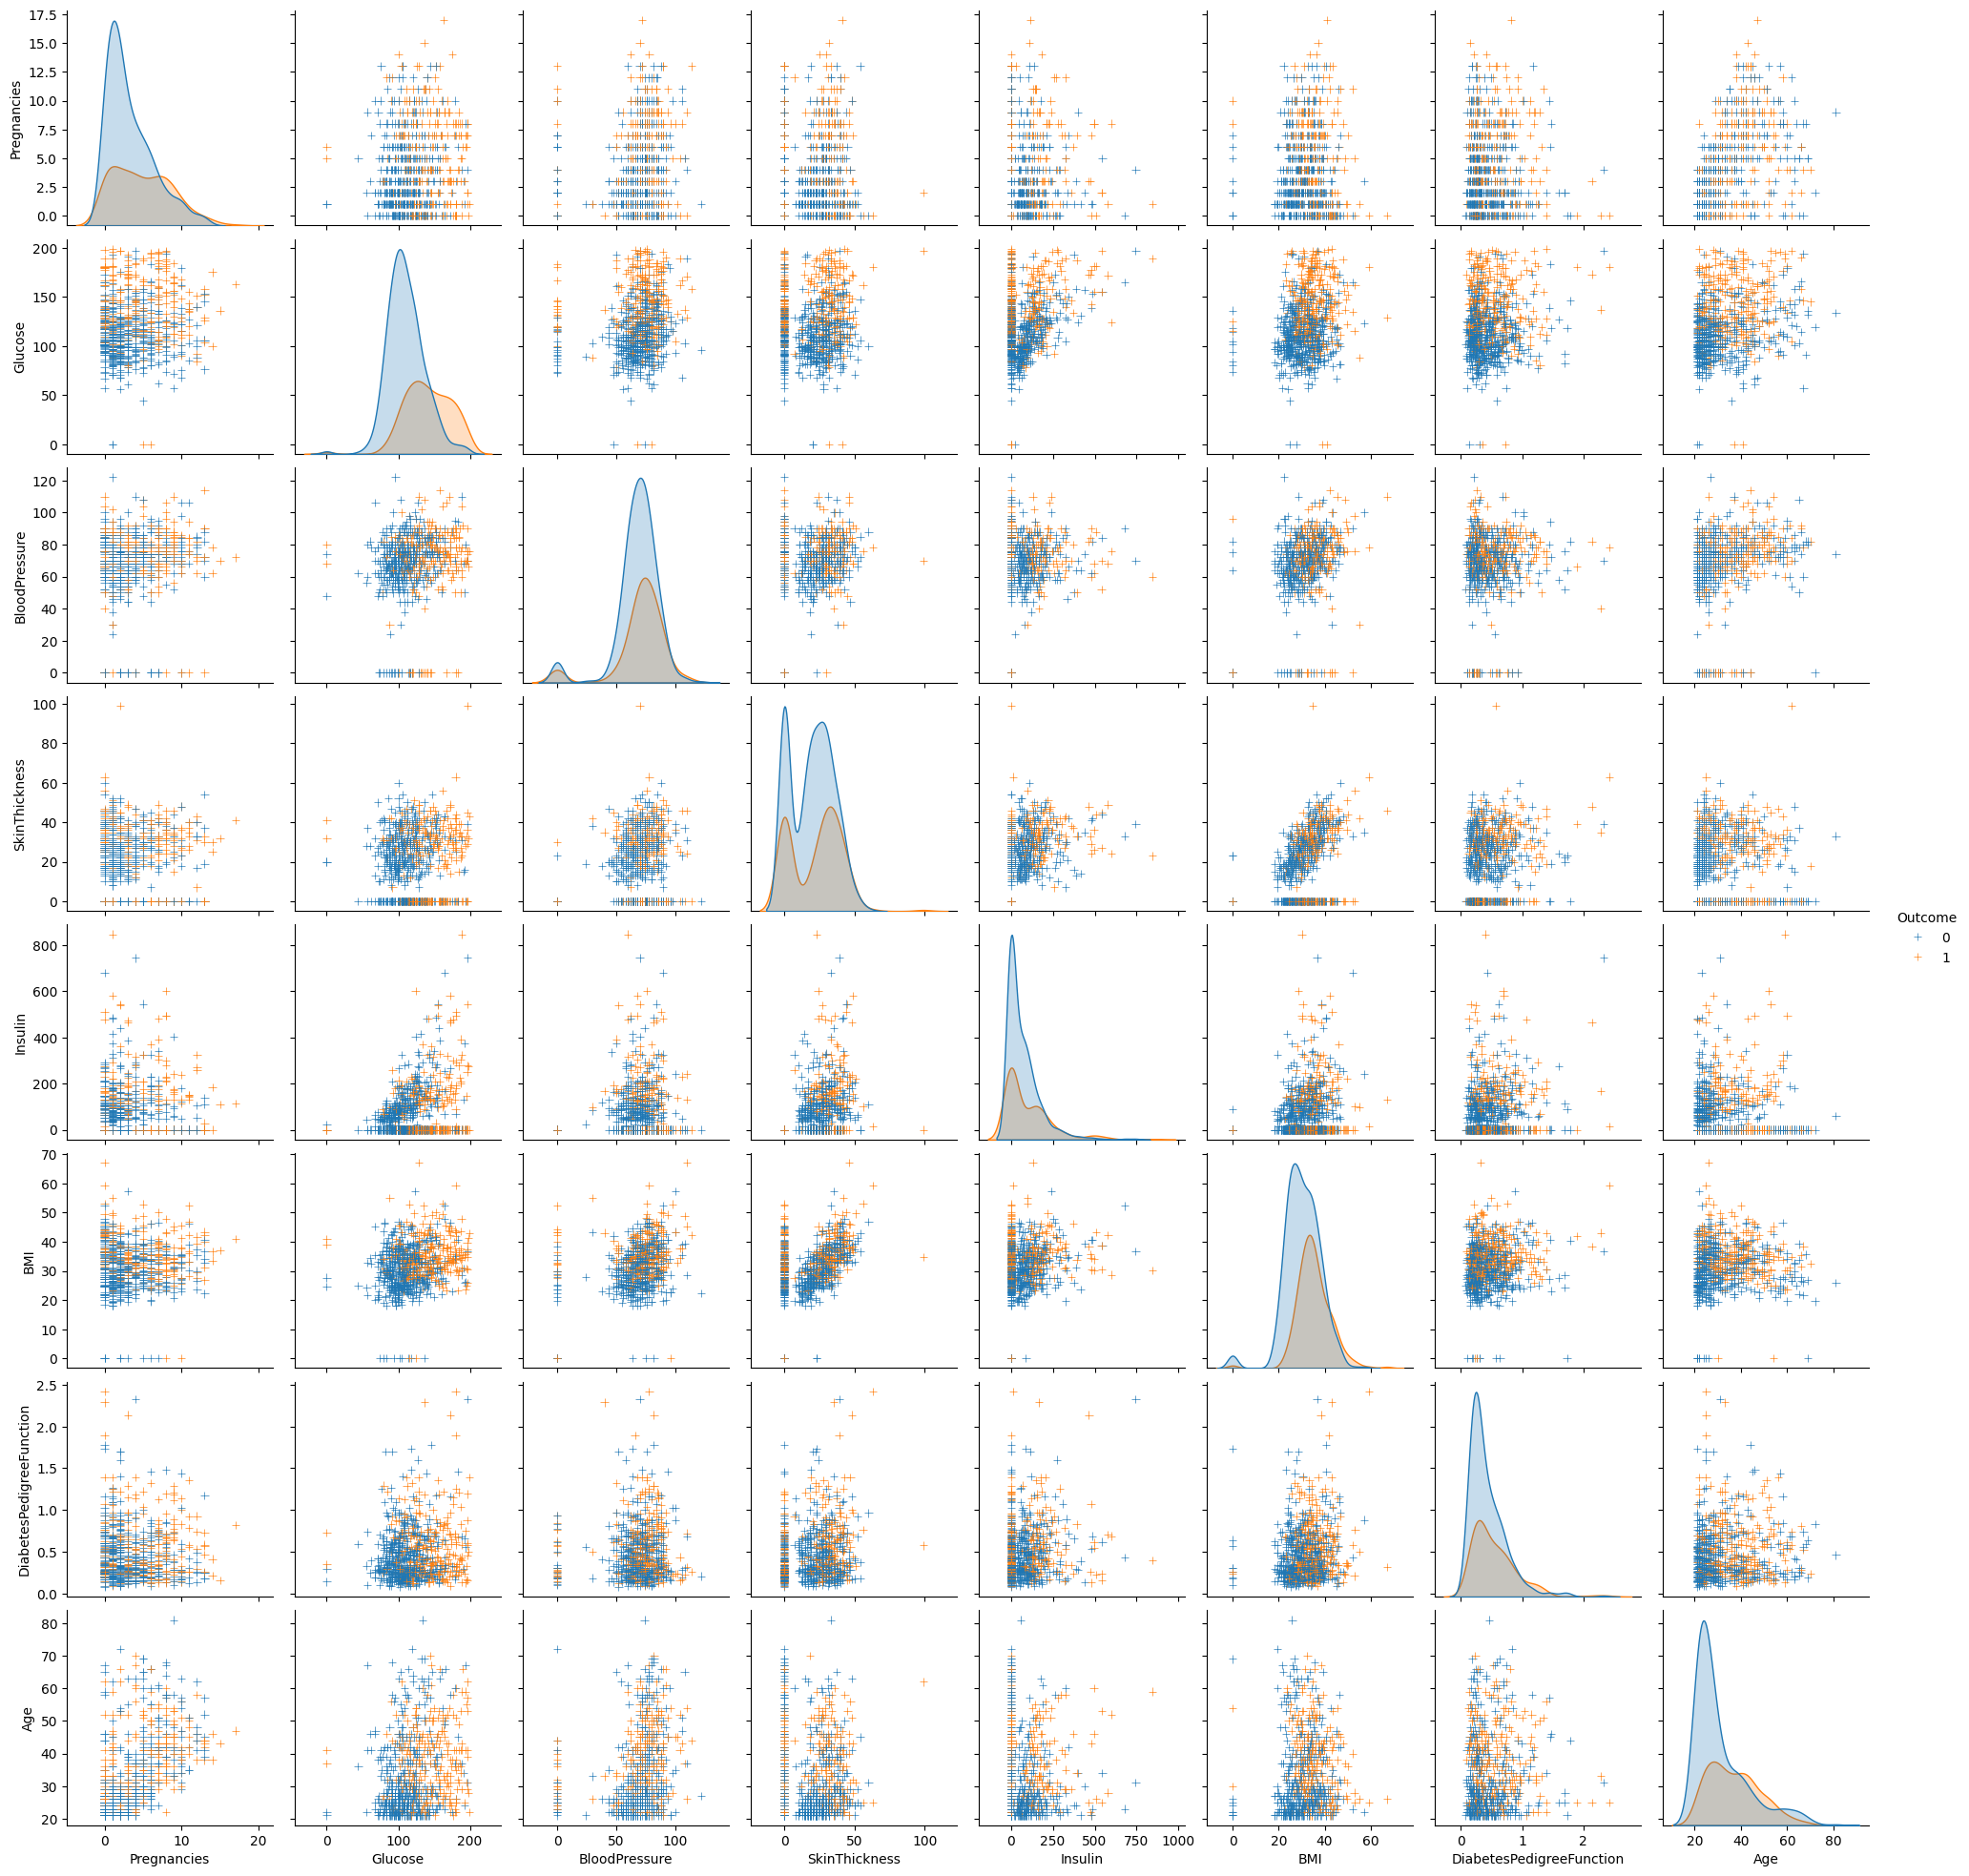

In [85]:
sns.pairplot(df, markers='+', hue="Outcome")
plt.show()

<Axes: >

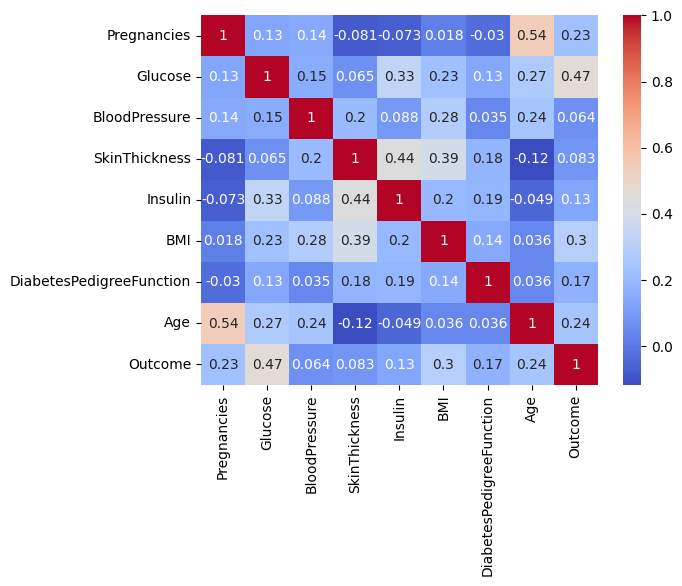

In [87]:
columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
data_included = df[columns]
sns.heatmap(data_included.corr(), annot=True, cmap='coolwarm')

Outcome
0    0.651656
1    0.348344
Name: proportion, dtype: float64


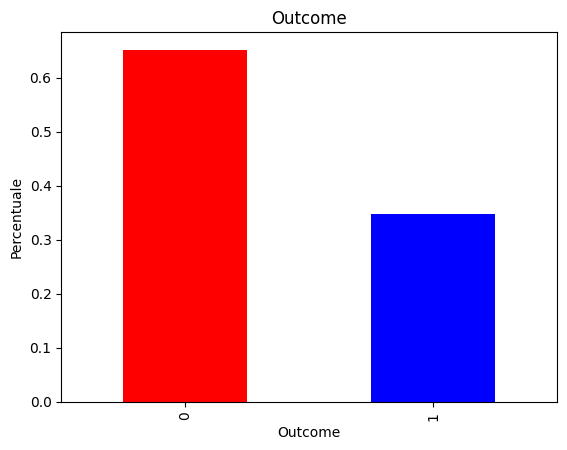

In [88]:
# istogramma della colonna di Outcome per vedere distribuzione dei positivi e negativi. Stampo la percentuale: 65% positivi, 35% negativi
print(df['Outcome'].value_counts(normalize=True))
df['Outcome'].value_counts(normalize=True).plot(kind='bar', color=['red', 'blue'])
plt.title('Outcome')
plt.xlabel('Outcome')
plt.ylabel('Percentuale')
plt.show()

In [89]:
#Eliminiamo i record con BMI vuoto
df = df[df['BMI'].notnull()]

# Random Forest

In [91]:
df.loc[:, df.columns != 'Outcome']

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33
...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63
764,2,122,70,27,0,36.8,0.340,27
765,5,121,72,23,112,26.2,0.245,30
766,1,126,60,0,0,30.1,0.349,47


In [92]:
from sklearn import tree
X = df.loc[:, df.columns != 'Outcome']
Y = df['Outcome']
clf = tree.DecisionTreeClassifier(random_state=42, max_depth=2)
clf = clf.fit(X, Y)

[Text(0.5, 0.8333333333333334, 'x[1] <= 127.5\ngini = 0.454\nsamples = 755\nvalue = [492, 263]'),
 Text(0.25, 0.5, 'x[7] <= 28.5\ngini = 0.312\nsamples = 476\nvalue = [384, 92]'),
 Text(0.125, 0.16666666666666666, 'gini = 0.156\nsamples = 269\nvalue = [246, 23]'),
 Text(0.375, 0.16666666666666666, 'gini = 0.444\nsamples = 207\nvalue = [138, 69]'),
 Text(0.75, 0.5, 'x[5] <= 29.95\ngini = 0.475\nsamples = 279\nvalue = [108, 171]'),
 Text(0.625, 0.16666666666666666, 'gini = 0.432\nsamples = 76\nvalue = [52, 24]'),
 Text(0.875, 0.16666666666666666, 'gini = 0.4\nsamples = 203\nvalue = [56, 147]')]

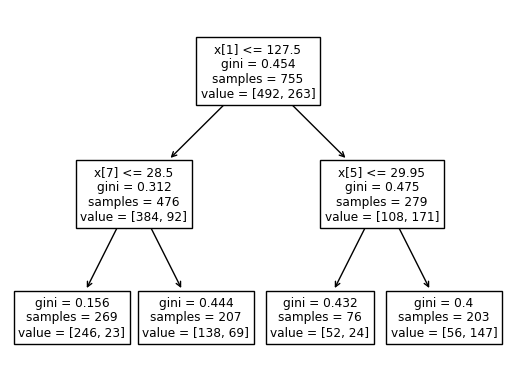

In [93]:
tree.plot_tree(clf)

In [94]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,755.000000,755.000000,755.000000,755.000000,755.000000,755.000000,755.000000,755.000000,755.000000
mean,3.854305,121.172185,68.998675,20.472848,79.713907,31.992450,0.472114,33.210596,0.348344
std,3.381172,31.667445,19.454190,15.991302,115.565133,7.951837,0.331941,11.784398,0.476762
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.200000,0.243500,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,29.000000,32.300000,0.370000,29.000000,0.000000
75%,6.000000,141.000000,80.000000,32.000000,126.500000,36.600000,0.628000,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [95]:
# Tra i pz con BMI Alto quale eta anno e che outcome hanno

# Split del dataset

In [96]:
from sklearn.model_selection import train_test_split

In [97]:
X_train = X
y_train = Y

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X_train,y_train, test_size=0.33, random_state=42)

In [99]:
clf = tree.DecisionTreeClassifier(random_state=42, max_depth=2)
clf = clf.fit(X_train, y_train)

[Text(0.5, 0.8333333333333334, 'x[1] <= 127.5\ngini = 0.453\nsamples = 505\nvalue = [330, 175]'),
 Text(0.25, 0.5, 'x[7] <= 28.5\ngini = 0.306\nsamples = 329\nvalue = [267, 62]'),
 Text(0.125, 0.16666666666666666, 'gini = 0.148\nsamples = 186\nvalue = [171, 15]'),
 Text(0.375, 0.16666666666666666, 'gini = 0.441\nsamples = 143\nvalue = [96, 47]'),
 Text(0.75, 0.5, 'x[5] <= 29.95\ngini = 0.46\nsamples = 176\nvalue = [63, 113]'),
 Text(0.625, 0.16666666666666666, 'gini = 0.426\nsamples = 39\nvalue = [27, 12]'),
 Text(0.875, 0.16666666666666666, 'gini = 0.387\nsamples = 137\nvalue = [36, 101]')]

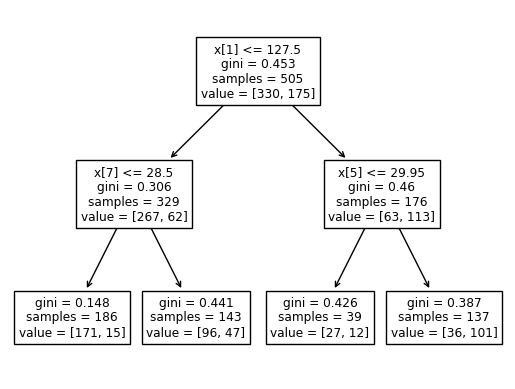

In [100]:
tree.plot_tree(clf)

In [101]:
from sklearn.metrics import classification_report

y_true = y_test
y_pred = clf.predict(X_test)
target_names = ['NO', 'YES']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

          NO       0.77      0.88      0.82       162
         YES       0.70      0.52      0.60        88

    accuracy                           0.75       250
   macro avg       0.73      0.70      0.71       250
weighted avg       0.75      0.75      0.74       250



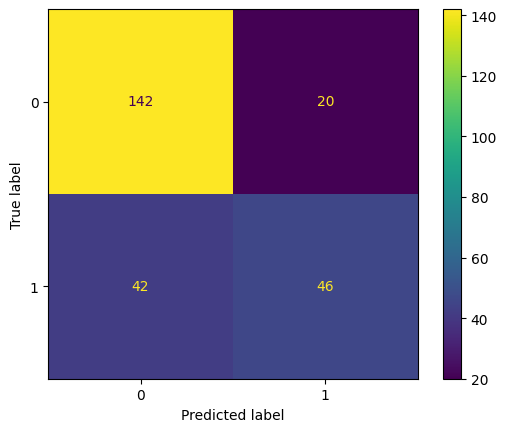

In [102]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

confusion_matrix(y_true, y_pred)
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=clf.classes_)
disp.plot()
plt.show()

PCA

In [103]:
import numpy as np
from sklearn.decomposition import PCA
import plotly.express as px
df = df[df['BMI'].notnull()]

pca = PCA(n_components='mle')
pca.fit(df[['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']],df[['Outcome']])
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

pca_features = pca.fit_transform(df[['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']],df[['Outcome']])

labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    pca_features,
    labels=labels,
    dimensions=range(7),
    color=df["Outcome"]
)
fig.update_traces(diagonal_visible=False)
fig.show()

print('Shape before PCA: ', df.shape)
print('Shape after PCA: ', pca_features.shape)


t = pd.DataFrame(pca_features)
t['Outcome'] = df['Outcome']

[8.89695359e-01 6.03595495e-02 2.58567363e-02 1.31246213e-02
 7.39241279e-03 3.04999108e-03 5.14536354e-04]
[3193.84080962  831.88941467  544.47689656  387.9144828   291.12916053
  187.00012123   76.80697053]


Shape before PCA:  (755, 9)
Shape after PCA:  (755, 7)


In [105]:
from flaml import AutoML


# Initialize an AutoML instance
automl = AutoML()
# Specify automl goal and constraint
automl_settings = {
    "time_budget": 60,  # in seconds
    "metric": 'f1',
    "task": 'classification',
    "log_file_name": "iris.log",
}

# Train with labeled input data
automl.fit(X_train=X_train, y_train=y_train, **automl_settings)
# Predict
print(automl.predict_proba(X_train))
# Print the best model
print(automl.model.estimator)

[flaml.automl.logger: 04-15 18:47:06] {1680} INFO - task = classification
[flaml.automl.logger: 04-15 18:47:06] {1691} INFO - Evaluation method: cv
[flaml.automl.logger: 04-15 18:47:06] {1789} INFO - Minimizing error metric: 1-f1
[flaml.automl.logger: 04-15 18:47:06] {1901} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl.logger: 04-15 18:47:06] {2219} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 04-15 18:47:06] {2345} INFO - Estimated sufficient time budget=1122s. Estimated necessary time budget=26s.
[flaml.automl.logger: 04-15 18:47:06] {2392} INFO -  at 0.1s,	estimator lgbm's best error=1.0000,	best estimator lgbm's best error=1.0000
[flaml.automl.logger: 04-15 18:47:06] {2219} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 04-15 18:47:07] {2392} INFO -  at 0.2s,	estimator lgbm's best error=1.0000,	best estimator lgbm's best error=1.0000
[flaml.automl.logger: 04-15 18:47:07] {2

INFO:flaml.tune.searcher.blendsearch:No low-cost partial config given to the search algorithm. For cost-frugal search, consider providing low-cost values for cost-related hps via 'low_cost_partial_config'. More info can be found at https://microsoft.github.io/FLAML/docs/FAQ#about-low_cost_partial_config-in-tune
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn

[flaml.automl.logger: 04-15 18:47:55] {2392} INFO -  at 48.4s,	estimator lrl1's best error=0.5520,	best estimator xgboost's best error=0.3086
[flaml.automl.logger: 04-15 18:47:55] {2219} INFO - iteration 76, current learner lrl1


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[flaml.automl.logger: 04-15 18:47:55] {2392} INFO -  at 48.7s,	estimator lrl1's best error=0.5520,	best estimator xgboost's best error=0.3086
[flaml.automl.logger: 04-15 18:47:55] {2219} INFO - iteration 77, current learner lrl1


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[flaml.automl.logger: 04-15 18:47:55] {2392} INFO -  at 48.9s,	estimator lrl1's best error=0.5520,	best estimator xgboost's best error=0.3086
[flaml.automl.logger: 04-15 18:47:55] {2219} INFO - iteration 78, current learner lrl1


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[flaml.automl.logger: 04-15 18:47:55] {2392} INFO -  at 49.1s,	estimator lrl1's best error=0.5520,	best estimator xgboost's best error=0.3086
[flaml.automl.logger: 04-15 18:47:55] {2219} INFO - iteration 79, current learner lrl1


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[flaml.automl.logger: 04-15 18:47:56] {2392} INFO -  at 49.6s,	estimator lrl1's best error=0.5520,	best estimator xgboost's best error=0.3086
[flaml.automl.logger: 04-15 18:47:56] {2219} INFO - iteration 80, current learner lrl1


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[flaml.automl.logger: 04-15 18:47:56] {2392} INFO -  at 50.0s,	estimator lrl1's best error=0.5520,	best estimator xgboost's best error=0.3086
[flaml.automl.logger: 04-15 18:47:56] {2219} INFO - iteration 81, current learner xgb_limitdepth


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[flaml.automl.logger: 04-15 18:47:57] {2392} INFO -  at 50.4s,	estimator xgb_limitdepth's best error=0.3450,	best estimator xgboost's best error=0.3086
[flaml.automl.logger: 04-15 18:47:57] {2219} INFO - iteration 82, current learner lrl1


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[flaml.automl.logger: 04-15 18:47:57] {2392} INFO -  at 50.7s,	estimator lrl1's best error=0.5520,	best estimator xgboost's best error=0.3086
[flaml.automl.logger: 04-15 18:47:57] {2219} INFO - iteration 83, current learner lrl1


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[flaml.automl.logger: 04-15 18:47:57] {2392} INFO -  at 50.9s,	estimator lrl1's best error=0.5520,	best estimator xgboost's best error=0.3086
[flaml.automl.logger: 04-15 18:47:57] {2219} INFO - iteration 84, current learner lrl1


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[flaml.automl.logger: 04-15 18:47:58] {2392} INFO -  at 51.4s,	estimator lrl1's best error=0.5520,	best estimator xgboost's best error=0.3086
[flaml.automl.logger: 04-15 18:47:58] {2219} INFO - iteration 85, current learner lrl1


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[flaml.automl.logger: 04-15 18:47:58] {2392} INFO -  at 51.8s,	estimator lrl1's best error=0.5520,	best estimator xgboost's best error=0.3086
[flaml.automl.logger: 04-15 18:47:58] {2219} INFO - iteration 86, current learner lrl1


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[flaml.automl.logger: 04-15 18:47:59] {2392} INFO -  at 52.3s,	estimator lrl1's best error=0.5520,	best estimator xgboost's best error=0.3086
[flaml.automl.logger: 04-15 18:47:59] {2219} INFO - iteration 87, current learner lrl1


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[flaml.automl.logger: 04-15 18:47:59] {2392} INFO -  at 52.9s,	estimator lrl1's best error=0.5520,	best estimator xgboost's best error=0.3086
[flaml.automl.logger: 04-15 18:47:59] {2219} INFO - iteration 88, current learner lrl1


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[flaml.automl.logger: 04-15 18:48:00] {2392} INFO -  at 53.5s,	estimator lrl1's best error=0.5520,	best estimator xgboost's best error=0.3086
[flaml.automl.logger: 04-15 18:48:00] {2219} INFO - iteration 89, current learner extra_tree


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[flaml.automl.logger: 04-15 18:48:01] {2392} INFO -  at 54.5s,	estimator extra_tree's best error=0.4457,	best estimator xgboost's best error=0.3086
[flaml.automl.logger: 04-15 18:48:01] {2219} INFO - iteration 90, current learner xgboost
[flaml.automl.logger: 04-15 18:48:02] {2392} INFO -  at 55.6s,	estimator xgboost's best error=0.3086,	best estimator xgboost's best error=0.3086
[flaml.automl.logger: 04-15 18:48:02] {2219} INFO - iteration 91, current learner lrl1


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[flaml.automl.logger: 04-15 18:48:02] {2392} INFO -  at 56.1s,	estimator lrl1's best error=0.5520,	best estimator xgboost's best error=0.3086
[flaml.automl.logger: 04-15 18:48:02] {2219} INFO - iteration 92, current learner lrl1


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[flaml.automl.logger: 04-15 18:48:03] {2392} INFO -  at 56.6s,	estimator lrl1's best error=0.5520,	best estimator xgboost's best error=0.3086
[flaml.automl.logger: 04-15 18:48:03] {2219} INFO - iteration 93, current learner lrl1


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/

[flaml.automl.logger: 04-15 18:48:03] {2392} INFO -  at 57.2s,	estimator lrl1's best error=0.5520,	best estimator xgboost's best error=0.3086
[flaml.automl.logger: 04-15 18:48:03] {2219} INFO - iteration 94, current learner lrl1


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[flaml.automl.logger: 04-15 18:48:04] {2392} INFO -  at 57.7s,	estimator lrl1's best error=0.5520,	best estimator xgboost's best error=0.3086
[flaml.automl.logger: 04-15 18:48:04] {2219} INFO - iteration 95, current learner lrl1


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[flaml.automl.logger: 04-15 18:48:05] {2392} INFO -  at 58.2s,	estimator lrl1's best error=0.5520,	best estimator xgboost's best error=0.3086
[flaml.automl.logger: 04-15 18:48:05] {2219} INFO - iteration 96, current learner rf


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[flaml.automl.logger: 04-15 18:48:05] {2392} INFO -  at 58.7s,	estimator rf's best error=0.3467,	best estimator xgboost's best error=0.3086
[flaml.automl.logger: 04-15 18:48:05] {2219} INFO - iteration 97, current learner lrl1
[flaml.automl.logger: 04-15 18:48:05] {2392} INFO -  at 59.0s,	estimator lrl1's best error=0.5520,	best estimator xgboost's best error=0.3086


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[flaml.automl.logger: 04-15 18:48:05] {2219} INFO - iteration 98, current learner extra_tree
[flaml.automl.logger: 04-15 18:48:06] {2392} INFO -  at 59.4s,	estimator extra_tree's best error=0.4457,	best estimator xgboost's best error=0.3086
[flaml.automl.logger: 04-15 18:48:06] {2219} INFO - iteration 99, current learner lrl1


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[flaml.automl.logger: 04-15 18:48:06] {2392} INFO -  at 59.7s,	estimator lrl1's best error=0.5520,	best estimator xgboost's best error=0.3086
[flaml.automl.logger: 04-15 18:48:06] {2219} INFO - iteration 100, current learner lrl1
[flaml.automl.logger: 04-15 18:48:06] {2392} INFO -  at 60.0s,	estimator lrl1's best error=0.5520,	best estimator xgboost's best error=0.3086


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[flaml.automl.logger: 04-15 18:48:06] {2628} INFO - retrain xgboost for 0.2s
[flaml.automl.logger: 04-15 18:48:06] {2631} INFO - retrained model: XGBClassifier(base_score=None, booster=None, callbacks=[],
              colsample_bylevel=0.8184166881476597, colsample_bynode=None,
              colsample_bytree=0.8110207792444197, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy='lossguide', importance_type=None,
              interaction_constraints=None, learning_rate=0.5305016568114994,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=0, max_leaves=4,
              min_child_weight=0.5873610441060633, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=4,
              n_jobs=-1, num_parallel_tree=None, random_state=None, ...)
[flaml.automl.logger: 04-15 18:4

In [106]:
y_pred = automl.predict(X_test)

In [107]:
X_train = X
y_train = Y

In [108]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

clf = RandomForestClassifier(max_features=0.34266499205249945, max_leaf_nodes=7,
                       n_estimators=4, n_jobs=-1, random_state=12032022)
clf.fit(X_train, y_train)


RandomForestClassifier(max_features=0.34266499205249945, max_leaf_nodes=7,
                       n_estimators=4, n_jobs=-1, random_state=12032022)

In [109]:
from sklearn.metrics import classification_report
y_true = y_test
y_pred = clf.predict(X_test)
target_names = ['NO', 'YES']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

          NO       0.74      0.93      0.82       162
         YES       0.74      0.39      0.51        88

    accuracy                           0.74       250
   macro avg       0.74      0.66      0.66       250
weighted avg       0.74      0.74      0.71       250



In [110]:
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

          NO       0.74      0.93      0.82       162
         YES       0.74      0.39      0.51        88

    accuracy                           0.74       250
   macro avg       0.74      0.66      0.66       250
weighted avg       0.74      0.74      0.71       250



# Modifica delle variabili

In [111]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from scipy.stats import randint
import seaborn as sns
from sklearn import metrics


# SEED all random generators
seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)

df = pd.read_csv("https://raw.githubusercontent.com/w4bo/handsOnDataPipelines/main/materials/datasets/diabetes.mod.csv")
df

,Unnamed: 0,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0,6,148,72,35,0,33.6,0.627,50,Y
1,1,1,85,66,29,0,26.6,0.351,31,N
2,2,8,183,64,0,0,23.3,0.672,32,Y
3,3,1,89,66,23,94,28.1,0.167,21,N
4,4,0,137,40,35,168,43.1,2.288,33,Y
...,...,...,...,...,...,...,...,...,...,...
763,763,10,101,76,48,180,32.9,0.171,63,N
764,764,2,122,70,27,0,36.8,0.340,27,N
765,765,5,121,72,23,112,26.2,0.245,30,N
766,766,1,126,60,0,0,30.1,0.349,47,Y


In [112]:
# Rimozione colonna index non necessaria
df.drop(columns=df.columns[0], axis=1,  inplace=True)

In [113]:
df = df[df['BMI'].notnull()]

In [114]:
# Bin 'BMI' into categories
import numpy as np
bins = [-1, 18.5, 25, 30, 35, 40, np.inf]
labels = ['Underweight', 'Normal', 'Overweight', 'Overweight 2', 'Overweight 3', 'Overweight 4']
df['BMI_Category'] = pd.cut(df['BMI'], bins=bins, labels=labels)

# i valori di insulina a 0 lo trasformo in NaN
df['Insulin'].replace(0, np.nan, inplace=True)
# i valori di SkinThickness a 0 lo trasformo in NaN
df['SkinThickness'].replace(0, np.nan, inplace=True)

# Calcolo la media rispetto al BMI e rispetto all'Outcome
mean_values = df.groupby(['BMI_Category', 'Outcome'])[['Insulin', 'SkinThickness']].mean()
# Applico per ogni categoria di BMI e per ogni Outcome (Outcome = 0 o 1) il valor medio per insulina e pelle

# Loop over each 'BMI_Category' and 'Outcome' and apply the means to the missing insulin and skin thickness values
for bmi_cat in labels:
    for outcome in df['Outcome'].unique():  # This will iterate over each unique value in 'Outcome' column
        df.loc[(df['Insulin'].isnull()) & (df['BMI_Category'] == bmi_cat) & (df['Outcome'] == outcome), 'Insulin'] = mean_values.loc[(bmi_cat, outcome), 'Insulin']
        df.loc[(df['SkinThickness'].isnull()) & (df['BMI_Category'] == bmi_cat) & (df['Outcome'] == outcome), 'SkinThickness'] = mean_values.loc[(bmi_cat, outcome), 'SkinThickness']

# Riporto in numerico la classe categorica di BMI
df['BMI_Category'] = df['BMI_Category'].map({'Underweight': 0, 'Normal': 1, 'Overweight': 2, 'Overweight 2': 3, 'Overweight 3': 4, 'Overweight 4': 5})
# Calculate overall mean for 'Insulin' and 'SkinThickness'
overall_mean_insulin = df['Insulin'].mean()
overall_mean_skinthickness = df['SkinThickness'].mean()
def convert_to_binary(value):
    if value == 'Y':
        return 1
    elif value == 'N':
        return 0
    else:
        return None

df['Outcome'] = df['Outcome'].apply(convert_to_binary)

# Fill remaining nulls with overall mean
df['Insulin'].fillna(overall_mean_insulin, inplace=True)
df['SkinThickness'].fillna(overall_mean_skinthickness, inplace=True)
df.drop(columns='BMI',axis=1,inplace=True)
df

<ipython-input-114-1f70f387a603>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-114-1f70f387a603>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-114-1f70f387a603>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-114-1f70f387a603>:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try u

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,DiabetesPedigreeFunction,Age,Outcome,BMI_Category
0,6,148,72,35.000000,221.260870,0.627,50,1,3
1,1,85,66,29.000000,108.014286,0.351,31,0,2
2,8,183,64,15.000000,96.000000,0.672,32,1,1
3,1,89,66,23.000000,94.000000,0.167,21,0,2
4,0,137,40,35.000000,168.000000,2.288,33,1,5
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48.000000,180.000000,0.171,63,0,3
764,2,122,70,27.000000,158.019608,0.340,27,0,4
765,5,121,72,23.000000,112.000000,0.245,30,0,2
766,1,126,60,32.333333,221.260870,0.349,47,1,3


In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 755 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Pregnancies               755 non-null    int64   
 1   Glucose                   755 non-null    int64   
 2   BloodPressure             755 non-null    int64   
 3   SkinThickness             755 non-null    float64 
 4   Insulin                   755 non-null    float64 
 5   DiabetesPedigreeFunction  755 non-null    float64 
 6   Age                       755 non-null    int64   
 7   Outcome                   755 non-null    int64   
 8   BMI_Category              755 non-null    category
dtypes: category(1), float64(3), int64(5)
memory usage: 54.0 KB


#Normalizzazione

In [116]:
from sklearn.preprocessing import MinMaxScaler

In [117]:
X = df.loc[:, df.columns != 'Outcome']
Y = df['Outcome']

In [118]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.33, random_state=42)
len(X_train)


505

In [119]:
# Initialize an AutoML instance
automl = AutoML()
# Specify automl goal and constraint
automl_settings = {
    "time_budget": 120,  # in seconds
    "metric": 'f1',
    "task": 'classification',
    "log_file_name": "iris.log",
}

# Train with labeled input data
automl.fit(X_train=X_train, y_train=y_train,
           **automl_settings)
# Predict
print(automl.predict_proba(X_train))
# Print the best model
print(automl.model.estimator)

[flaml.automl.logger: 04-15 18:48:08] {1680} INFO - task = classification
[flaml.automl.logger: 04-15 18:48:08] {1691} INFO - Evaluation method: cv
[flaml.automl.logger: 04-15 18:48:08] {1789} INFO - Minimizing error metric: 1-f1
[flaml.automl.logger: 04-15 18:48:08] {1901} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl.logger: 04-15 18:48:08] {2219} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 04-15 18:48:09] {2345} INFO - Estimated sufficient time budget=10959s. Estimated necessary time budget=253s.
[flaml.automl.logger: 04-15 18:48:09] {2392} INFO -  at 1.2s,	estimator lgbm's best error=0.4978,	best estimator lgbm's best error=0.4978
[flaml.automl.logger: 04-15 18:48:09] {2219} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 04-15 18:48:10] {2392} INFO -  at 2.0s,	estimator lgbm's best error=0.4978,	best estimator lgbm's best error=0.4978
[flaml.automl.logger: 04-15 18:48:10] 

In [120]:
print(automl.predict_proba(X_train))
# Print the best model
print(automl.model.estimator)

[[0.0462892  0.9537108 ]
 [0.99297529 0.00702471]
 [0.04292171 0.95707829]
 ...
 [0.96996342 0.03003658]
 [0.02345333 0.97654667]
 [0.93122106 0.06877894]]
LGBMClassifier(learning_rate=0.17277910497967483, max_bin=127,
               min_child_samples=16, n_estimators=1, n_jobs=-1, num_leaves=23,
               reg_alpha=0.00558798314291954, reg_lambda=1.0455673832429768,
               verbose=-1)


In [121]:
y_pred = automl.predict(X_test)
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

          NO       0.89      0.90      0.90       162
         YES       0.81      0.80      0.80        88

    accuracy                           0.86       250
   macro avg       0.85      0.85      0.85       250
weighted avg       0.86      0.86      0.86       250



# pOST NOrmalizzazione

In [122]:
y_pred = automl.predict(X_test)
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

          NO       0.89      0.90      0.90       162
         YES       0.81      0.80      0.80        88

    accuracy                           0.86       250
   macro avg       0.85      0.85      0.85       250
weighted avg       0.86      0.86      0.86       250



# 2 minuti , er mejo

In [123]:
y_pred = automl.predict(X_test)
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

          NO       0.89      0.90      0.90       162
         YES       0.81      0.80      0.80        88

    accuracy                           0.86       250
   macro avg       0.85      0.85      0.85       250
weighted avg       0.86      0.86      0.86       250

